In [51]:
import time
import os
import torch
import json
import random
import numpy as np
import pandas as pd
import wandb
%matplotlib widget
from datetime import datetime
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, MiniBatchKMeans
from dataload.data_utils import loadH5Full
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.autograd as autograd
from config import getConfig
from agents import get_agent

random.seed(2021)
DATA_DIR = "data/Chair"
JSON_DIR = "data/parts_json"
RESOLUTION = 64

def readJsonPartCategories(chairID, nParts):
    categories = []
    path = os.path.join(JSON_DIR, chairID, "result.json")
    try:
        f = open(path)
        data = json.load(f)
        for (i, el) in enumerate(data[0]['children']):
            partName = el['text']
            if partName == "Chair Back":
                categories.append(1)
            elif partName == "Chair Seat":
                categories.append(2)
            elif partName == "Chair Arm":
                categories.append(3)
            elif partName == "Chair Base":
                # this will also apply to following parts
                for j in range(i, nParts):
                    categories.append(4)
        f.close()
    except Exception as e:
        categories = [0]*nParts # missing corresponding json labels for h5
    return categories[0:nParts] # sometimes json file has more labels than voxelized parts, in which case results are truncated

def getChairPartInfos(encoder, filename):
    path = os.path.join(DATA_DIR, filename)

    nParts, partVoxel, dataPoints, dataVals, scales, translations, size = loadH5Full(path, resolution=RESOLUTION)
    voxelTensor = torch.tensor(partVoxel.astype(np.float), dtype=torch.float32).unsqueeze(1)  # (nParts, 1, dim, dim, dim)
    with torch.no_grad():
        latentVecs = encoder(voxelTensor.cuda()).cpu().numpy()
    nParts = latentVecs.shape[0]
    strid = filename[0:-3]
    categories = np.array(readJsonPartCategories(strid, nParts))

    # numpy arrays
    # vecs: (nParts, latent dimension)
    # scales: (nParts, 1)
    # translations: (nParts, 3)
    # categories: (nParts)
    return {'vecs':latentVecs, 'scales':scales, 'translations':translations, 'categories':categories,
            'matchedCategories': len(categories)==len(latentVecs), 'filename':filename}


def loadAllChairsInfoIterable():
    # part latent vectors, categories, and affine transforms
    filenames = filter(lambda filename:filename.endswith(".h5"), os.listdir(DATA_DIR))

    config = getConfig()
    agent = get_agent("partae", config)
    agent.loadChkPt(config.ckpt)
    config.resolution = RESOLUTION
    encoder = agent.net.encoder
    
    chairInfos = filter(lambda x:x is not None, map(lambda filename: getChairPartInfos(encoder, filename), filenames))
    
    return chairInfos

Error in callback <function _WandbInit._resume_backend at 0x7f1d507fc840> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7f1d507fcbf8> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [2]:
exampleChairParts = next(iter(loadAllChairsInfoIterable()))

Checkpoint loaded from chkt_dir/partae/latest.pth


In [3]:
exampleChairParts.keys()

dict_keys(['vecs', 'scales', 'translations', 'categories', 'matchedCategories'])

In [4]:
latentDim = exampleChairParts['vecs'].shape[1]
exampleChairParts['vecs'].shape

(6, 128)

In [5]:
exampleChairParts['scales'].shape

(6, 1)

In [6]:
exampleChairParts['translations'].shape

(6, 3)

In [7]:
exampleChairParts['categories'].shape

(6,)

In [8]:
chairInfo = list(loadAllChairsInfoIterable())

Checkpoint loaded from chkt_dir/partae/latest.pth


In [9]:
# some chairInfo elements have mismatched number of categories and vecs for some reason, which would make visualization invalid if present
chairInfoSubset = random.sample(list(filter(lambda x:x['matchedCategories'], chairInfo)), 999)

In [10]:
vecsSubset = np.concatenate(list(map(lambda x:x['vecs'], chairInfoSubset)))
labsSubset = np.concatenate(list(map(lambda x:x['categories'], chairInfoSubset)))
normalizedVecsSubset = normalize(vecsSubset)
pcaObjSubset = PCA(n_components=20)
pcaOutSubset = pcaObjSubset.fit_transform(normalizedVecsSubset)
pcaObjSubset.explained_variance_ratio_.cumsum() # explains 82% of variance using with just 3 hyperplanes

array([0.50408876, 0.76486063, 0.822521  , 0.8521129 , 0.87372446,
       0.8916454 , 0.9016309 , 0.9111888 , 0.9177249 , 0.9234511 ,
       0.92795694, 0.93219435, 0.9361187 , 0.9397013 , 0.94265234,
       0.9452997 , 0.9477394 , 0.950024  , 0.9522223 , 0.9540279 ],
      dtype=float32)

Text(0.5, 0, 'z translation')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
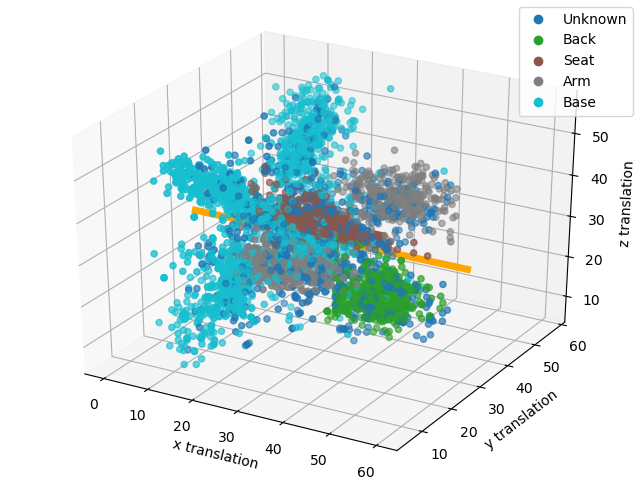

In [13]:
# plotting translation distribution
translationsSubset = np.concatenate(list(map(lambda x:x['translations'], chairInfoSubset)))

centroidYZSubset = np.mean(translationsSubset, axis=0)
centroidYZSubset[0] = 0

fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(
    xs = translationsSubset[:, 0],
    ys = translationsSubset[:, 1],
    zs = translationsSubset[:, 2],
    c = labsSubset,
    cmap='tab10'
)

ax.plot3D([centroidYZSubset[0], centroidYZSubset[0]+60], [centroidYZSubset[1], centroidYZSubset[1]], [centroidYZSubset[2], centroidYZSubset[2]], 'orange', linewidth=5)

handles, labels = scatter.legend_elements()
ax.legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])
ax.set_xlabel('x translation')
ax.set_ylabel('y translation')
ax.set_zlabel('z translation')

Text(0.5, 0, 'z translation')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
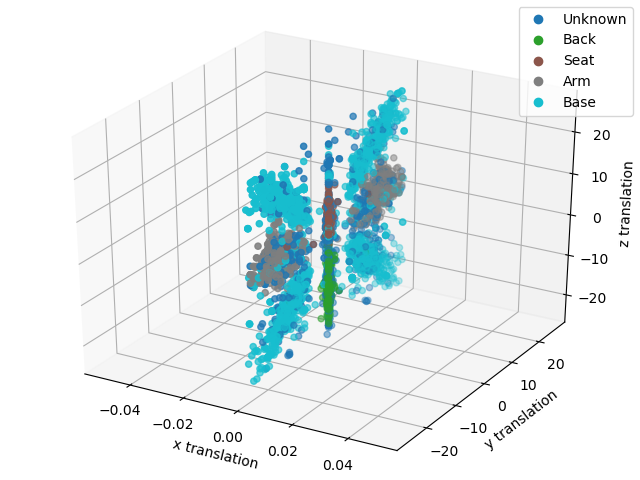

In [14]:
fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(
    xs = 0,
    ys = translationsSubset[:, 1] - centroidYZSubset[1],
    zs = translationsSubset[:, 2] - centroidYZSubset[2],
    c = labsSubset,
    cmap='tab10'
)

handles, labels = scatter.legend_elements()
ax.legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])
ax.set_xlabel('x translation')
ax.set_ylabel('y translation')
ax.set_zlabel('z translation')

Text(0.5, 0, 'third PCA hyperplane')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
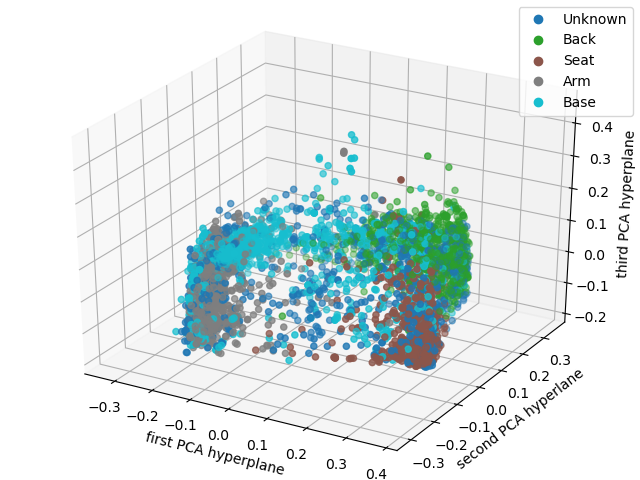

In [15]:
fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(
    xs = pcaOutSubset[:, 0],
    ys = pcaOutSubset[:, 1],
    zs = pcaOutSubset[:, 2],
    c = labsSubset,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax.legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])
ax.set_xlabel('first PCA hyperplane')
ax.set_ylabel('second PCA hyperlane')
ax.set_zlabel('third PCA hyperplane')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5575 samples in 0.001s...
[t-SNE] Computed neighbors for 5575 samples in 0.376s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5575
[t-SNE] Computed conditional probabilities for sample 2000 / 5575
[t-SNE] Computed conditional probabilities for sample 3000 / 5575
[t-SNE] Computed conditional probabilities for sample 4000 / 5575
[t-SNE] Computed conditional probabilities for sample 5000 / 5575
[t-SNE] Computed conditional probabilities for sample 5575 / 5575
[t-SNE] Mean sigma: 0.104186
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.397888
[t-SNE] KL divergence after 300 iterations: 1.864158
t-SNE done! Time elapsed: 2.8742871284484863 seconds


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
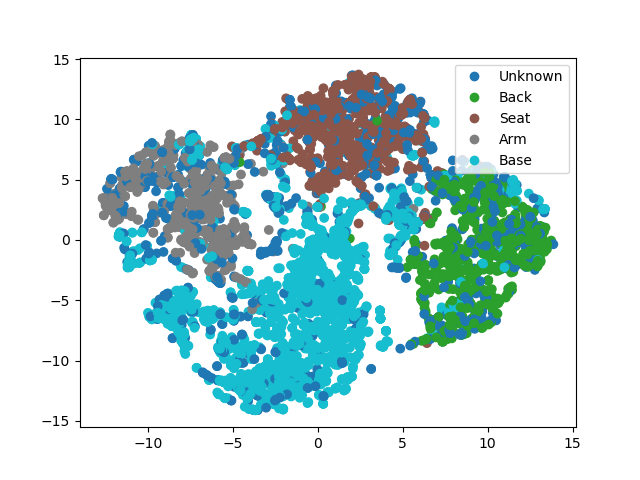

In [16]:
fig, ax = plt.subplots()



time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(vecsSubset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

scatter = ax.scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = labsSubset,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax.legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])

Spectral clustering (4 cluster) done! Time elapsed: 1.8439979553222656 seconds
Spectral clustering (5 cluster) done! Time elapsed: 1.8401756286621094 seconds
Spectral clustering (6 cluster) done! Time elapsed: 1.8505518436431885 seconds
K-means clustering (4 cluster) done! Time elapsed: 0.06510758399963379 seconds
K-means clustering (5 cluster) done! Time elapsed: 0.036900997161865234 seconds
K-means clustering (6 cluster) done! Time elapsed: 0.03962898254394531 seconds


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
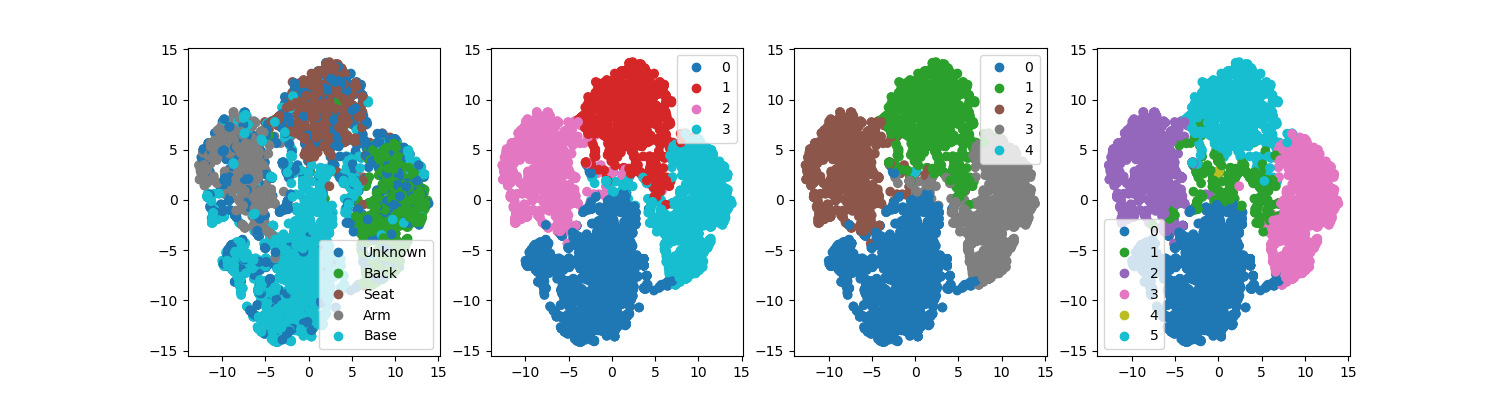

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
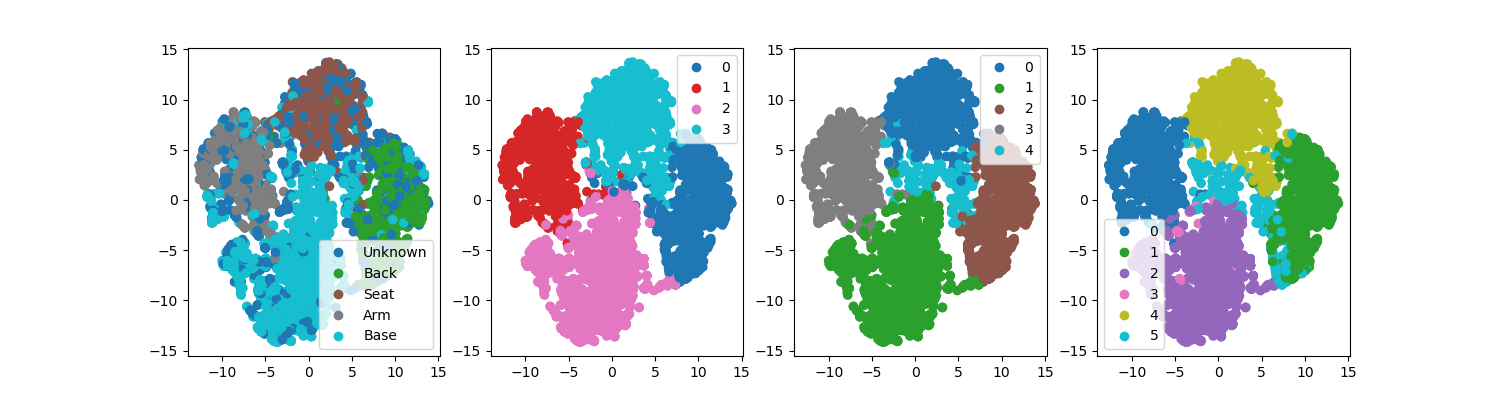

In [17]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))
scatter = ax[0].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = labsSubset,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[0].legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])





time_start = time.time()
clusterLabels = SpectralClustering(n_clusters=4,
                                   assign_labels='discretize',
                                   random_state=0).fit(vecsSubset).labels_
print('Spectral clustering (4 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[1].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[1].legend(handles, labels)




time_start = time.time()
clusterLabels = SpectralClustering(n_clusters=5,
                                   assign_labels='discretize',
                                   random_state=0).fit(vecsSubset).labels_
print('Spectral clustering (5 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[2].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[2].legend(handles, labels)





time_start = time.time()
clusterLabels = SpectralClustering(n_clusters=6,
                                   assign_labels='discretize',
                                   random_state=0).fit(vecsSubset).labels_
print('Spectral clustering (6 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[3].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[3].legend(handles, labels)


















fig, ax = plt.subplots(1,4, figsize=(15, 4))

scatter = ax[0].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = labsSubset,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[0].legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])





time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=4,
                                random_state=0).fit(vecsSubset).labels_
print('K-means clustering (4 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[1].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[1].legend(handles, labels)




time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=5,
                                random_state=0).fit(vecsSubset).labels_
print('K-means clustering (5 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[2].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[2].legend(handles, labels)





time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=6,
                                random_state=0).fit(vecsSubset).labels_
print('K-means clustering (6 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[3].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[3].legend(handles, labels)

K-means clustering (4 cluster) done! Time elapsed: 0.018384933471679688 seconds
K-means clustering (5 cluster) done! Time elapsed: 0.03573107719421387 seconds
K-means clustering (6 cluster) done! Time elapsed: 0.02810811996459961 seconds
K-means clustering (4 cluster) done! Time elapsed: 0.0165102481842041 seconds
K-means clustering (5 cluster) done! Time elapsed: 0.04249715805053711 seconds
K-means clustering (6 cluster) done! Time elapsed: 0.03442072868347168 seconds
K-means clustering (4 cluster) done! Time elapsed: 0.014413833618164062 seconds
K-means clustering (5 cluster) done! Time elapsed: 0.02936840057373047 seconds
K-means clustering (6 cluster) done! Time elapsed: 0.030292034149169922 seconds


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
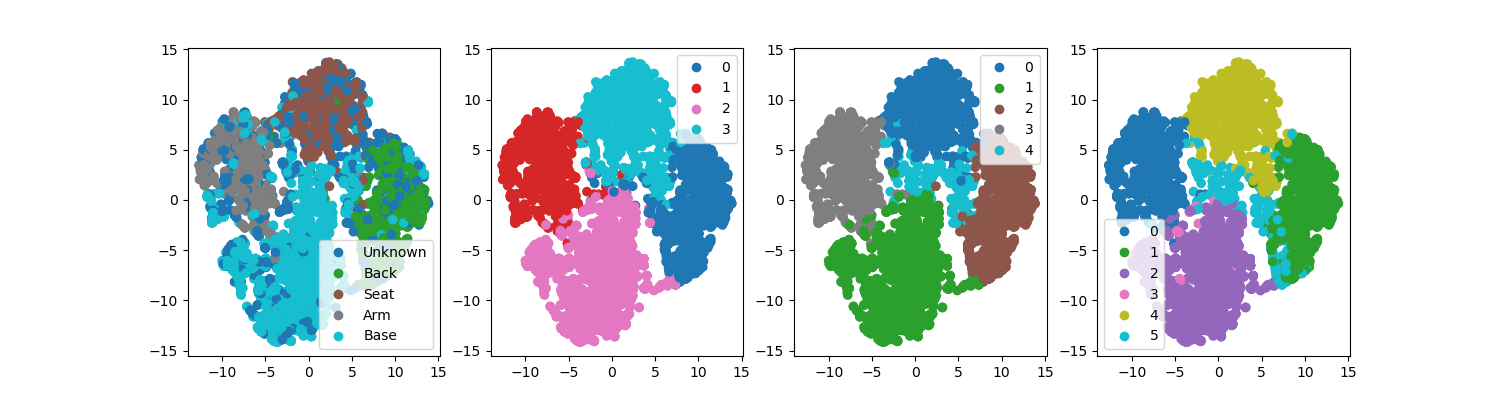

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
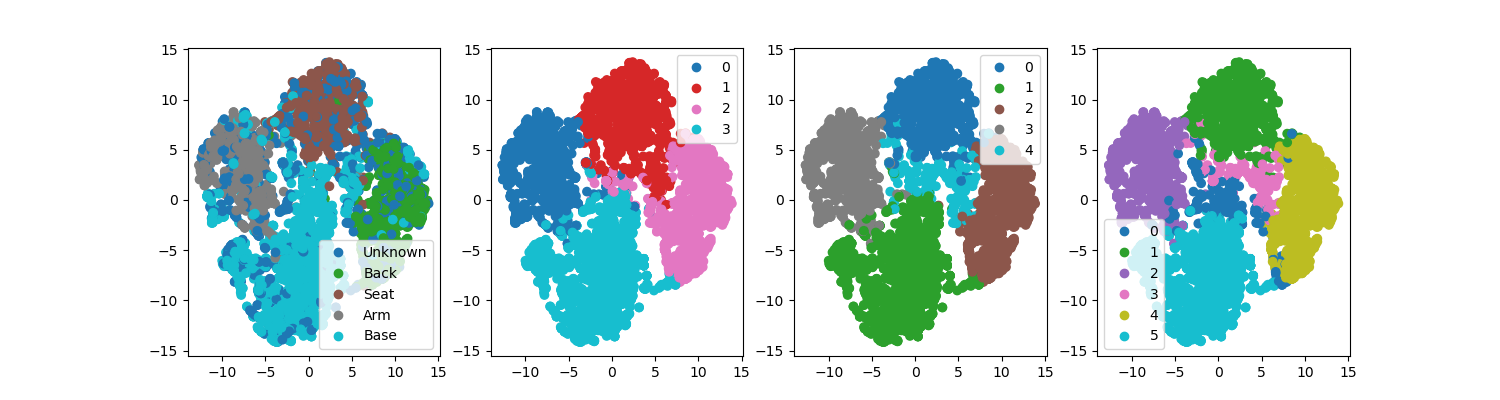

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
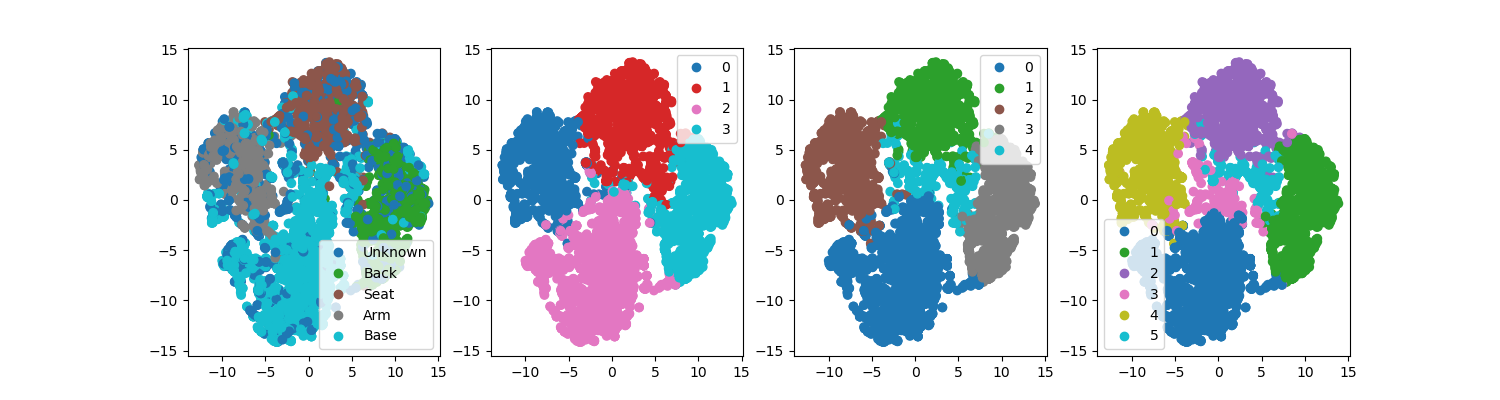

In [18]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))

scatter = ax[0].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = labsSubset,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[0].legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])





time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=4,
                                random_state=0).fit(vecsSubset).labels_
print('K-means clustering (4 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[1].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[1].legend(handles, labels)




time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=5,
                                random_state=0).fit(vecsSubset).labels_
print('K-means clustering (5 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[2].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[2].legend(handles, labels)





time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=6,
                                random_state=0).fit(vecsSubset).labels_
print('K-means clustering (6 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[3].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[3].legend(handles, labels)











fig, ax = plt.subplots(1,4, figsize=(15, 4))
scatter = ax[0].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = labsSubset,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[0].legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])
time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=4,
                                random_state=0).fit(normalizedVecsSubset).labels_
print('K-means clustering (4 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[1].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[1].legend(handles, labels)




time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=5,
                                random_state=0).fit(normalizedVecsSubset).labels_
print('K-means clustering (5 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[2].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[2].legend(handles, labels)





time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=6,
                                random_state=0).fit(normalizedVecsSubset).labels_
print('K-means clustering (6 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[3].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[3].legend(handles, labels)






fig, ax = plt.subplots(1,4, figsize=(15, 4))
scatter = ax[0].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = labsSubset,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[0].legend(handles, ['Unknown', 'Back', 'Seat', 'Arm', 'Base'])
time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=4,
                                random_state=0).fit(pcaOutSubset).labels_
print('K-means clustering (4 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[1].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[1].legend(handles, labels)







time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=5,
                                random_state=0).fit(pcaOutSubset).labels_
print('K-means clustering (5 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[2].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[2].legend(handles, labels)





time_start = time.time()
clusterLabels = MiniBatchKMeans(n_clusters=6,
                                random_state=0).fit(pcaOutSubset).labels_
print('K-means clustering (6 cluster) done! Time elapsed: {} seconds'.format(time.time()-time_start))
scatter = ax[3].scatter(
    x = tsne_results[:, 0],
    y = tsne_results[:, 1],
    c = clusterLabels,
    cmap='tab10'
)
handles, labels = scatter.legend_elements()
ax[3].legend(handles, labels)

Text(0.5, 0, 'z translation')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
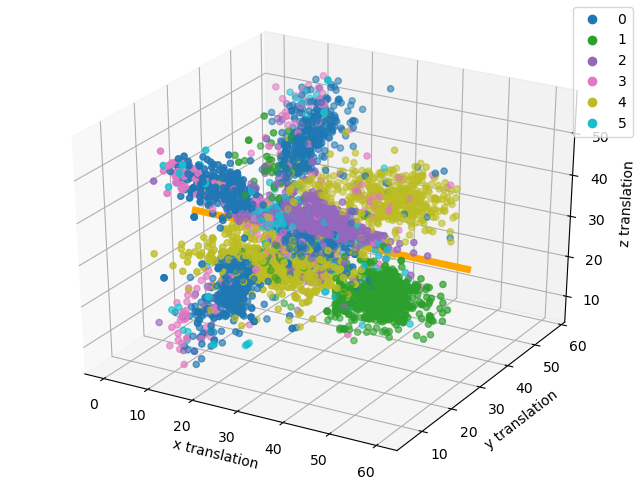

In [46]:
fig = plt.figure()
ax = Axes3D(fig)
scatter = ax.scatter(
    xs = translationsSubset[:, 0],
    ys = translationsSubset[:, 1],
    zs = translationsSubset[:, 2],
    c = clusterLabels,
    cmap='tab10'
)

ax.plot3D([centroidYZSubset[0], centroidYZSubset[0]+60], [centroidYZSubset[1], centroidYZSubset[1]], [centroidYZSubset[2], centroidYZSubset[2]], 'orange', linewidth=5)

handles, labels = scatter.legend_elements()
ax.legend(handles, labels)
ax.set_xlabel('x translation')
ax.set_ylabel('y translation')
ax.set_zlabel('z translation')

In [19]:
vecs = np.concatenate(list(map(lambda x:x['vecs'], chairInfo)))
normalized_vecs = normalize(vecs)
pca_obj = PCA(n_components=75)
pca_out = pca_obj.fit_transform(normalized_vecs)
variance_preserved_at_dimension = pca_obj.explained_variance_ratio_.cumsum()
variance_preserved_at_dimension

array([0.5077017 , 0.7635498 , 0.82174426, 0.85177094, 0.872912  ,
       0.8915543 , 0.90161234, 0.9110952 , 0.91758144, 0.9232663 ,
       0.92784166, 0.9320862 , 0.9358719 , 0.939442  , 0.9422711 ,
       0.94482297, 0.94727635, 0.94952285, 0.95158046, 0.9535032 ,
       0.95522755, 0.95690674, 0.9584188 , 0.9598242 , 0.96115875,
       0.9623947 , 0.96360004, 0.9646966 , 0.9657717 , 0.96681124,
       0.9678088 , 0.9687539 , 0.96967155, 0.9705764 , 0.97139615,
       0.9721776 , 0.97294366, 0.9736837 , 0.97441   , 0.9750846 ,
       0.9757358 , 0.9763682 , 0.9769838 , 0.97758585, 0.9781756 ,
       0.9787474 , 0.9793034 , 0.9798464 , 0.9803753 , 0.98088723,
       0.981387  , 0.9818787 , 0.98236215, 0.98283625, 0.983292  ,
       0.9837377 , 0.9841659 , 0.9845923 , 0.9850151 , 0.98542494,
       0.98582995, 0.9862237 , 0.98661244, 0.98698694, 0.9873597 ,
       0.9877161 , 0.9880629 , 0.9884077 , 0.9887453 , 0.9890729 ,
       0.9893861 , 0.98969454, 0.99000245, 0.9903018 , 0.99059

In [20]:
threshold = 0.95
num_dim = np.argmax(variance_preserved_at_dimension > threshold) + 1
pca_out = pca_out[:, 0:num_dim]
num_dim

19

In [21]:
kmfit_6 = MiniBatchKMeans(n_clusters=6,
                          random_state=0,
                          compute_labels=False).fit(pca_out)
kmfit_8 = MiniBatchKMeans(n_clusters=8,
                          random_state=0,
                          compute_labels=False).fit(pca_out)
kmfit_10 = MiniBatchKMeans(n_clusters=10,
                           random_state=0,
                           compute_labels=False).fit(pca_out)

In [22]:
np.bincount(kmfit_6.predict(pca_obj.transform(chairInfo[3]['vecs'])[:, 0:num_dim]), minlength=6)

array([4, 1, 1, 0, 0, 0])

In [23]:
chairInfo[0].keys()

dict_keys(['vecs', 'scales', 'translations', 'categories', 'matchedCategories'])

In [24]:
def get_part_clusters_for_chairs_iterable(kmfit):
    return map(lambda d:{'clusters':kmfit.predict(pca_obj.transform(d['vecs'])[:, 0:num_dim]), 'scales':d['scales'], 'translations':d['translations']}, chairInfo)

def max_part_count_on_chair(kmfit, chairPartClusteredInfo):
    return np.amax(np.stack(list(map(lambda d:np.bincount(d['clusters'], minlength=kmfit.n_clusters), chairPartClusteredInfo))), axis=0)

def p_percentile_part_count_on_chair(kmfit, chairPartClusteredInfo, p):
    return np.percentile(np.stack(list(map(lambda d:np.bincount(d['clusters'], minlength=kmfit.n_clusters), chairPartClusteredInfo))), q=p, axis=0)

In [25]:
chairPartClusters = list(get_part_clusters_for_chairs_iterable(kmfit_6))
maxs = max_part_count_on_chair(kmfit_6, chairPartClusters)
p99s = p_percentile_part_count_on_chair(kmfit_6, chairPartClusters, 99)
p95s = p_percentile_part_count_on_chair(kmfit_6, chairPartClusters, 95)
p90s = p_percentile_part_count_on_chair(kmfit_6, chairPartClusters, 90)
print(maxs)
print(maxs.sum())
print(p99s)
print(p99s.sum())
print(p95s)
print(p95s.sum())
print(p90s)
print(p90s.sum())

[6 5 6 7 8 8]
40
[5. 3. 3. 4. 4. 4.]
23.0
[4. 2. 2. 3. 1. 4.]
16.0
[4. 1. 2. 2. 1. 2.]
12.0


In [26]:
chairPartClusters = list(get_part_clusters_for_chairs_iterable(kmfit_8))
maxs = max_part_count_on_chair(kmfit_8, chairPartClusters)
p99s = p_percentile_part_count_on_chair(kmfit_8, chairPartClusters, 99)
p95s = p_percentile_part_count_on_chair(kmfit_8, chairPartClusters, 95)
p90s = p_percentile_part_count_on_chair(kmfit_8, chairPartClusters, 90)
print(maxs)
print(maxs.sum())
print(p99s)
print(p99s.sum())
print(p95s)
print(p95s.sum())
print(p90s)
print(p90s.sum())

[6 6 5 5 7 6 6 4]
45
[5. 3. 3. 4. 4. 2. 4. 1.]
26.0
[4. 2. 2. 1. 3. 1. 4. 1.]
18.0
[4. 2. 1. 0. 2. 1. 2. 0.]
12.0


In [27]:
chairPartClusters = list(get_part_clusters_for_chairs_iterable(kmfit_10))
maxs = max_part_count_on_chair(kmfit_10, chairPartClusters)
p99s = p_percentile_part_count_on_chair(kmfit_10, chairPartClusters, 99)
p95s = p_percentile_part_count_on_chair(kmfit_10, chairPartClusters, 95)
p90s = p_percentile_part_count_on_chair(kmfit_10, chairPartClusters, 90)
print(maxs)
print(maxs.sum())
print(p99s)
print(p99s.sum())
print(p95s)
print(p95s.sum())
print(p90s)
print(p90s.sum())

[6 6 5 6 7 5 6 5 8 4]
58
[5. 3. 3. 2. 4. 1. 4. 1. 4. 1.]
28.0
[4. 2. 2. 1. 3. 1. 4. 1. 1. 0.]
19.0
[4. 1. 1. 0. 2. 1. 2. 0. 0. 0.]
11.0


In [31]:
# https://stackoverflow.com/a/13849249
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# def chair_part_category_average_translation_angular_differences(chairClusterDict, el_transform, n_cluster):
#     avg_angular_differences = np.zeros(n_cluster, dtype=float)
#     translations = chairClusterDict['translations']
#     for cluster_id in range(n_cluster):
#         matched_part_indices = np.where(chairClusterDict['clusters']==cluster_id)[0]
#         matched_translations = translations[matched_part_indices]
#         n = len(matched_translations)
#         if n > 0:
#             for x in matched_translations:
#                 vec1 = x * el_transform
#                 for y in matched_translations:
#                     vec2 = y * el_transform
#                     avg_angular_differences[cluster_id] += angle_between(vec1, vec2)
#             avg_angular_differences[cluster_id] = avg_angular_differences[cluster_id] / (n*n)
#     return avg_angular_differences

# def part_cluster_expected_plane_angular_differences(kmfit):
#     partClustersDicts = list(get_part_clusters_for_chairs_iterable(kmfit))
#     n_chairs = len(partClustersDicts)
#     n_cluster = kmfit.n_clusters
    
#     el_transform = np.ones(3, dtype=int)
#     avg_diff = np.mean(list(map(lambda d:chair_part_category_average_translation_angular_differences(d, el_transform, n_cluster), partClustersDicts)), axis=0)
#     print(avg_diff, avg_diff.sum())
    
#     axes = [0, 1, 2]
#     for axis in axes:
#         el_transform = np.ones(3, dtype=int)
#         el_transform[axis] = 0
#         avg_diff = np.mean(list(map(lambda d:chair_part_category_average_translation_angular_differences(d, el_transform, n_cluster), partClustersDicts)), axis=0)
#         print(axis, avg_diff, avg_diff.sum())

# part_cluster_expected_plane_angular_differences(kmfit_6)
# part_cluster_expected_plane_angular_differences(kmfit_8)
# part_cluster_expected_plane_angular_differences(kmfit_10)
centroid = np.mean(np.concatenate(list(map(lambda x:x['translations'], chairInfo))), axis=0)
reference_yz_vector = np.zeros(3, dtype=float)
reference_yz_vector[2] = 1.0
proj_onto_yz = np.array([0.0,1.0,1.0])

In [50]:
def vectorize_chair_info(maxCountPerCluster, chairClusterDict):
    maxCountPerCluster = maxCountPerCluster.astype(int)
    clusterEndIndices = maxCountPerCluster.cumsum()
    clusterStartIndices = clusterEndIndices - maxCountPerCluster
    count_dim = clusterEndIndices[-1]
    affine_dim = clusterEndIndices[-1] * 4
    count_vec = np.zeros(count_dim, dtype=bool)
    affine_vec = np.zeros(affine_dim, dtype=float)
    for (cluster_id, (cluster_max_count, cluster_start_index)) in enumerate(zip(maxCountPerCluster, clusterStartIndices)):
        matched_part_indices = np.where(chairClusterDict['clusters']==cluster_id)[0]
        matched_affines = []
        for (part_num, part_index) in enumerate(matched_part_indices):
            if part_num == cluster_max_count:
                break
            part_start_index = cluster_start_index + part_num
            count_vec[part_start_index] = True
            matched_affines.append([part_num, chairClusterDict['scales'][part_index], chairClusterDict['translations'][part_index]])
        matched_affines.sort(key=lambda x:angle_between((x[2]-centroid)*proj_onto_yz, reference_yz_vector)) # sort by rotational angle w.r.t. centroid on yz plane
        for (part_num, scale, translation) in matched_affines:
            part_start_index = cluster_start_index + part_num
            affine_vec[part_start_index*4] = scale
            affine_vec[part_start_index*4+1:part_start_index*4+4] = translation
    return {'count':count_vec, 'affine':affine_vec}

class GanDataset(Dataset):
    def __init__(self, kmfit, max_count_percentile):
        super(GanDataset, self).__init__()
        partClustersDicts = list(get_part_clusters_for_chairs_iterable(kmfit))
        maxCountPerCluster = p_percentile_part_count_on_chair(kmfit, partClustersDicts, max_count_percentile)
        self.chairVectorDicts = list(map(lambda d:vectorize_chair_info(maxCountPerCluster, d), get_part_clusters_for_chairs_iterable(kmfit)))
        self.countDim = int(maxCountPerCluster.sum())
        self.affineDim = int(self.countDim * 4)
        
    def __len__(self):
        return len(self.chairVectorDicts)
    
    def __getitem__(self, index):
        d = self.chairVectorDicts[index]
        return {'count':torch.cuda.BoolTensor(d['count']), 'affine':torch.cuda.FloatTensor(d['affine'])}


def engineer_feature_vec(counts, affines, quadratic):
    # counts: [bs, parts]
    # affines: [bs, parts*4]
    # mask: [bs, parts]
    bs = counts.shape[0]
    mask = (counts > 0.5).detach()
    affines = (affines.view(bs, -1, 4) * mask.unsqueeze(-1)).view(bs, -1)
    if quadratic:
        counts_quadric = counts.unsqueeze(-1) * counts.view(bs, 1, -1) # [bs, parts, parts]
        counts_quadric = counts_quadric.view(bs, -1) # [bs, parts*parts]
        features = torch.cat([counts_quadric, affines], dim=1) # [bs, parts^2 + parts*4]
    else:
        features = torch.cat([counts, affines], dim=1) # [bs, parts*5]
    return features
    
    
# based on https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py
class Generator(nn.Module):
    def __init__(self, latent_dim, count_dim, affine_dim):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            *block(1024, 2048)
        )
        self.count_layer = nn.Sequential(nn.Linear(2048, count_dim), nn.Sigmoid())
        self.affine_layer = nn.Sequential(nn.Linear(2048, affine_dim))

    def forward(self, z):
        features = self.model(z)
        counts = self.count_layer(features)
        affines = self.affine_layer(features)
        return {'count':counts, 'affine':affines}


class Discriminator(nn.Module):
    def __init__(self, count_dim, affine_dim, quadratic):
        super(Discriminator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        if quadratic:
            feature_dim = int(count_dim**2 + count_dim*4)
        else:
            feature_dim = int(count_dim*5)
        self.model = nn.Sequential(
            *block(feature_dim, 2048, normalize=False),
            *block(2048, 1024),
            *block(1024, 512),
            *block(512, 256),
            nn.Linear(256, 1)
        )
        

    def forward(self, features):
        validity = self.model(features)
        return validity

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.cuda.FloatTensor(np.random.random((real_samples.size(0), 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.cuda.FloatTensor(real_samples.shape[0], 1).fill_(1.0)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_wgan_gp(kmfit, quadratic_feature_engineering, n_epoch=50,
                  batch_size=64, learning_rate=0.00005, betas=[0.5, 0.999], latent_dim=128, lambda_gp=10, n_critic=5):
    wandb.init(project="764gan", entity="xda35")
    n_cluster = kmfit.n_clusters
    wandb.config = {
      "epochs": n_epoch,
      "learning_rate": learning_rate,
      "batch_size": batch_size,
      "n_critic": 5,
      "quadratic_features": quadratic_feature_engineering,
      "n_clusters": n_cluster
    }
    train_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    session_str = train_time + "_km" + str(n_cluster)
    if quadratic_feature_engineering:
        session_str = session_str + "_q/"
    wandb.run.name = session_str
    weights_dir = os.path.join("data/","weights/", session_str)
    gweights_dir = os.path.join(weights_dir, "generator/")
    dweights_dir = os.path.join(weights_dir, "discriminator/")
    
    ds = GanDataset(kmfit, 95)
    count_dim = ds.countDim
    affine_dim = ds.affineDim
    dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    generator = Generator(latent_dim, count_dim, affine_dim).cuda()
    discriminator = Discriminator(count_dim, affine_dim, quadratic_feature_engineering).cuda()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=betas)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=betas)
    for epoch in range(n_epoch):
        num_d_iter = 0
        num_g_iter = 0
        epoch_d_loss = torch.zeros(1).cuda()
        epoch_g_loss = torch.zeros(1).cuda()
        for i, real_batch in enumerate(dataloader):
            num_d_iter += 1
            real_count = real_batch['count']
            real_affine = real_batch['affine']
            real_features = engineer_feature_vec(real_count, real_affine, quadratic_feature_engineering)
            # ----------------------------------------
            # Train D()
            # ----------------------------------------
            optimizer_D.zero_grad()
            # sample noise for G()
            z = torch.cuda.FloatTensor(np.random.normal(0, 1, (real_features.shape[0], latent_dim)))
            with torch.no_grad():
                fake_batch = generator(z)
            fake_count = fake_batch['count']
            fake_affine = fake_batch['affine']
            fake_features = engineer_feature_vec(fake_count, fake_affine, quadratic_feature_engineering)
            real_validity = discriminator(real_features)
            fake_validity = discriminator(fake_features)
            gradient_penalty = compute_gradient_penalty(discriminator, real_features, fake_features)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            
            d_loss.backward()
            optimizer_D.step()
            optimizer_G.zero_grad()
            epoch_d_loss += d_loss.detach()
            if i % n_critic == 0:    
                num_g_iter += 1
                # ----------------------------------------
                # Train G()
                # ----------------------------------------
                fake_batch = generator(z)
                fake_count = fake_batch['count']
                fake_affine = fake_batch['affine']
                fake_features = engineer_feature_vec(fake_count, fake_affine, quadratic_feature_engineering)
                fake_validity = discriminator(fake_features)
                g_loss = -torch.mean(fake_validity)
                g_loss.backward()
                optimizer_G.step()
                epoch_g_loss += g_loss.detach()
        wandb.log({'epoch':epoch+1, 'epoch_d_loss':epoch_d_loss.item()/num_d_iter, 'epoch_g_loss':epoch_g_loss.item()/num_g_iter})
        
        torch.save(generator.state_dict(),gweights_dir)
        torch.save(discriminator.state_dict(),dweights_dir)

Error in callback <function _WandbInit._resume_backend at 0x7f1d507fc840> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7f1d507fcbf8> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [47]:
train_wgan_gp(kmfit_8, True, n_epoch=10000)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_d_loss,█▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
epoch_g_loss,▂▂▃▃▁▆█▅█▆▆▆▅▄▄▄▄▄▄▄▄▄▄▅▆▅▅▄▅▅▅▅▅▅▅▅▄▅▅▅
epoch,50
epoch_d_loss,-29.95312
epoch_g_loss,0.07408


KeyboardInterrupt: 